# TL;DR

* Using 6 weeks of on-chain data since the merge, we can start to look at real validator reward levels, with the inclusion of execution layer rewards.
* Execution layer rewards are significantly lower than they were in the year before the merge. This is most likely the result of market conditions.
* Rewards are very uneven at this stage, with around half of validators still yet to propose a block.
* No advantage was observed for large staking pools, in terms of rate of return. There is not yet enough data to establish whether they may have an edge.
* During the analysis period, third party block builders took over the majority of block building from valdators.
* Third party block builders consistently outperform validators who build their own blocks, and there is variation in performance between block builders.

# Introduction

In the [previous article](https://pintail.xyz/posts/post-merge-mev/) we attempted to model post-merge validator returns based on pre-merge data. Ethereum's merge finally occurred on 15 September 2022 (at a block height of 15537394 on the execution layer, and slot number 4700013 on the consensus layer). Now, with 6 weeks of post-merge data available we're going to take a look at the distribution of rewards actually earned by proof-of-stake validators, and compare this with the consensus layer rewards, and our model from the previous article. We'll also take a look at identifiable groups of validators and compare their performance to the network as a whole.

We'll also take a look at one of the most significant changes to occur in parallel with the merge, which is the outsourcing of block building by validators. This change came about because of the adoption of Flashbots' MEV-boost middleware. Prior to the merge, miners were able to accept "bundles" of transactions exploiting MEV opportunities, and were trusted to include them without stealing the MEV they contained (the topic of MEV was covered [in more detail](https://pintail.xyz/posts/post-merge-mev/#but-whats-mev) previously). This system worked because under proof-of-work, Ethereum blocks were built by only a small number of mining pools, these pools could be punished for misbehaving by simply cutting them off from receiving future profitable transaction bundles. The situation changed with the transition to proof-of-stake. Now, blocks can be built and proposed by a wide rang of actors including solo validators. It is no longer feasible for all of them to have trusted relationships with all of them.

The change that was made was to allow outsourced builders to produce entire blocks rather than just bundles of transactions — that way builders could produce a block header and get this signed by the proposer _without_ first releasing the body of the block and risking the MEV being stolen. What had not been widely understood prior to [OFAC's designation of the contracts associated with privacy layer Tornado Cash](https://home.treasury.gov/news/press-releases/jy0916), was that by outsourcing the entirety of block building, rather than just provision of transaction bundles, the issue of transaction censorship became a [more pressing concern](https://time.com/6223034/ethereum-merge-sanctions-flashbots/).

# Dataset, Pre-processing

To obtain the data, we're Flashbots' mev-inspect-py tool as before, but with some [minor modifications](https://github.com/pintail-xyz/mev-inspect-py/tree/since-the-merge) to allow for handling of post-merge blocks. Our dataset starts at the Merge block, and goes up to block number 15837692 which was mined on 27 October 2022, for a full 6 weeks of data. To allow us to make sense of this data in the context of proof-of-stake Ethereum, we need to do a couple of pieces of pre-processing.

## Step 1: Identify Validators

Since we're obtaining all our MEV data from the execution layer, this data initially contains no notion of proof-of-stake validators, with a validator index and public key. We therefore need to obtain this information from a consensus layer client. For this article we're using the [Nimbus](https://github.com/status-im/nimbus-eth2) consensus layer client to query the node for the [blocks directly](https://ethereum.github.io/beacon-APIs/#/Beacon/getBlockV2), to enable us to link an execution layer block height with its consensus layer slot number. We'll also query for the validator indices of the [proposers of each epoch](https://ethereum.github.io/beacon-APIs/#/Validator/getProposerDuties), to identify which validator proposed (or failed to propose) a block in each slot.

## Step 2: Identify Builders and Builder-payees

The final step is to identify cases where the validator has outsourced block building to a separate block builder. This is slightly less straightforward. On the execution layer, what used to be the "miner address" is now the "fee recipient". If the proposer has used a block builder, then this fee recipient will be set as the builder's address, but there is no record of the validator's own execution layer address provided — we will need to make some assumptions to determine it.

The proposing validator will need to be paid, and the most common way this is done is for the block produced by the builder to include a transaction which them the fees. In principle the proposing validator could be paid some other way (e.g. an 'out of band' or off-chain payment), but we will assume for this analysis that outsourced blocks include a fee payment to the proposer. We can identify such transactions from the mev-inspect-py database with the following SQL query:

So, we are making the assumption that if there is an outgoing transaction from the "miner address", in fact this address belongs to the block builder, and represents a fee payment being sent to the proposer. The results of running the above query have been saved in a [CSV file](https://github.com/pintail-xyz/since-the-merge/blob/main/fee_recipient_transactions.csv). The steps above have been written in a [python script](https://github.com/pintail-xyz/since-the-merge/blob/main/proposers.py) and the output written to a [CSV file](https://github.com/pintail-xyz/since-the-merge/blob/main/proposers.csv) which we will use for the remainder of this article.

# Execution Layer Rewards (a.k.a. MEV)

To start with let's take a look at the distribution of execution layer rewards across blocks. This data makes a direct comparison with the [historical MEV levels](https://pintail.xyz/posts/post-merge-mev/#historical-mev-levels) section of the previous article, updated with data from after the merge. We can see that compared with data from the full year before the merge, MEV levels are down between 30% (at the 10th centile) and 60% (at the 90th centile).

The distribution looks to have a broadly similar shape, with the exception of the two peaks at the low end of the histogram, which were not present in the previous distribution. It's possible that this is just noise, a result of having a much smaller dataset (6 weeks rather than 12 months). It will be interesting to see if this shape becomes clearer when more detail is available. However, from looking of the Empirically-derived Cumulative Density Function (ECDF), the overall shape seems very similar.

In [1]:
# imports and definitions

import csv
import json
import requests
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from statistics import median

CL_NODE_URL = 'http://localhost:5052'
SECONDS_PER_YEAR = 31556952
BEACON_CHAIN_GENESIS_TIMESTAMP = 1606824023

class Ecdf(pd.Series):
    def __init__(self, data):
        s = pd.Series(data)
        super().__init__(s.value_counts().sort_index().cumsum()*1./len(s))

    def get_quantile(self, q):
        return self.index[np.argmax(self.array >= q)]

In [2]:
# read in data from CSV, replace missing values as appropriate

with open('proposers.csv') as f:
    reader = csv.reader(f)
    headers = next(reader)
    data = {h: [] for h in headers}
    for row in reader:
        if len(row) != len(headers):
            print(row)
            break
        for index, item in enumerate(row):
            data[headers[index]].append(item)
    
data['slot'] = [int(item) for item in data['slot']]
data['val_index'] = [int(item) for item in data['val_index']]
data['block_number'] = [None if item == '' else int(item) for item in data['block_number']]
data['net_fees'] = [0 if item == '' else float(item) for item in data['net_fees']]
data['coinbase_transfer'] = [0 if item == '' else float(item) for item in data['coinbase_transfer']]

blocks_df = pd.DataFrame(data)

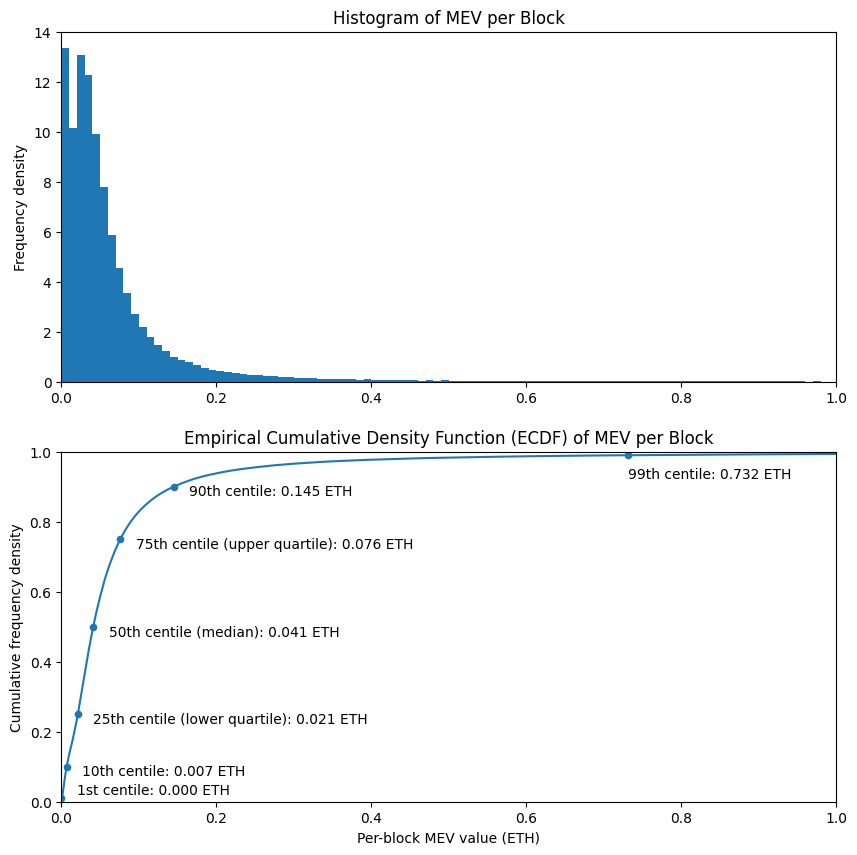

centile(%),revenue(ETH per block)
1.0,0.000
10.0,0.007
25.0,0.021
50.0,0.041
75.0,0.076
90.0,0.145
99.0,0.732
99.9,4.567


In [3]:
# plot ECDF, show quantiles for block value

blocks_df['block_value'] = (blocks_df['net_fees'] + blocks_df['coinbase_transfer']) / 1e18
blocks_ecdf = Ecdf(blocks_df['block_value'])

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

bins = [e/100 for e in range(101)]
blocks_df['block_value'].hist(ax=ax1, bins=bins, density=True, grid=False)
ax1.set_title('Histogram of MEV per Block')
ax1.set_xlim(0, 1)
ax1.set_ylabel('Frequency density')

quantiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999]
table = pd.DataFrame({
    'quantile': quantiles,
    'centile<br>(%)': [100 * q for q in quantiles],
    'revenue<br>(ETH per block)': [blocks_ecdf.get_quantile(q) for q in quantiles]
})

table.set_index('quantile', inplace=True, drop=False)
table.plot('revenue<br>(ETH per block)', 'quantile', kind='scatter', ax=ax2)

blocks_ecdf.plot(ax=ax2)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xlabel('Per-block MEV value (ETH)')
ax2.set_ylabel('Cumulative frequency density')
ax2.set_title('Empirical Cumulative Density Function (ECDF) of MEV per Block')
q01 = table['revenue<br>(ETH per block)'].loc[0.01]
ax2.annotate(f'1st centile: {q01:.3f} ETH', (q01 + 0.02, 0.02))
q1 = table['revenue<br>(ETH per block)'].loc[0.1]
ax2.annotate(f'10th centile: {q1:.3f} ETH', (q1 + 0.02, 0.075))
q25 = table['revenue<br>(ETH per block)'].loc[0.25]
ax2.annotate(f'25th centile (lower quartile): {q25:.3f} ETH', (q25 + 0.02, 0.225))
q5 = table['revenue<br>(ETH per block)'].loc[0.5]
ax2.annotate(f'50th centile (median): {q5:.3f} ETH', (q5 + 0.02, 0.475))
q75 = table['revenue<br>(ETH per block)'].loc[0.75]
ax2.annotate(f'75th centile (upper quartile): {q75:.3f} ETH', (q75 + 0.02, 0.725))
q9 = table['revenue<br>(ETH per block)'].loc[0.9]
ax2.annotate(f'90th centile: {q9:.3f} ETH', (q9 + 0.02, 0.875))
q99 = table['revenue<br>(ETH per block)'].loc[0.99]
ax2.annotate(f'99th centile: {q99:.3f} ETH', (q99, 0.925))

plt.show()
table[
    ['centile<br>(%)', 'revenue<br>(ETH per block)']
].style.set_table_styles(
    [dict(selector='th', props=[('text-align', 'center')])]
).hide().format(
    {'centile<br>(%)': '{:.1f}', 'revenue<br>(ETH per block)': '{:.3f}'}
)

# Validator Returns

To get the overall validator returns, we need to aggregate the execution layer rewards by validator, and add them to the consensus layer rewards. The consensus layer rewards for each validator for the period are calculated by querying the [validator balances](https://ethereum.github.io/beacon-APIs/#/Beacon/getStateValidators) at the start and end of the period under consideration, with the net reward given by the difference between the initial and final balance. These rewards and and the execution layer rewards are then aggregated per-validator and then turned into an Annual Percentage Return (APR) to enable us to compare these values irrespective of timescale.

In [4]:
# load validator/balance data

start_slot = blocks_df['slot'].min()
end_slot = blocks_df['slot'].max()

try:
    with open(str(start_slot) + '_validators.json') as f:
        start_validators = json.load(f)
except:
    r = requests.get(CL_NODE_URL + f'/eth/v1/beacon/states/{start_slot}/validators')
    start_validators = r.json()['data']
    with open(str(start_slot) + '_validators.json', 'w') as f:
        json.dump(start_validators, f)

try:
    with open(str(end_slot) + '_validators.json') as f:
        end_validators = json.load(f)
except:
    r = requests.get(CL_NODE_URL + f'/eth/v1/beacon/states/{end_slot}/validators')
    end_validators = r.json()['data']
    with open(str(end_slot) + '_validators.json', 'w') as f:
        json.dump(end_validators, f)

# calculate per-validator el and cl rewareds

validator_rewards = [
    {'index': -1, 'include': True, 'cl_rewards': 0, 'el_rewards': 0, 'num_proposals': 0, 'fee_recipient': '', 'builder_payee': ''}
    for i in range(len(end_validators))
]

for index, data in enumerate(end_validators):
    val = data['validator']
    validator_rewards[index]['index'] = index
    if int(val['activation_epoch']) > start_slot // 32 or int(val['exit_epoch']) < end_slot // 32:
        # exclude validators which were not active for part/all of the period
        validator_rewards[index]['include'] = False
    else:
        cl_rewards = (int(data['balance']) - int(start_validators[index]['balance'])) / 1e9
        validator_rewards[index]['cl_rewards'] = cl_rewards
        if cl_rewards < 0:
            # exclude dormant/abandoned validators
            validator_rewards[index]['include'] = False

for index, row in blocks_df.iterrows():
    val = validator_rewards[row['val_index']]
    val['el_rewards'] += row['block_value']
    val['num_proposals'] += 1
    val['fee_recipient'] = row['fee_recipient']
    val['builder_payee'] = row['builder_payee']

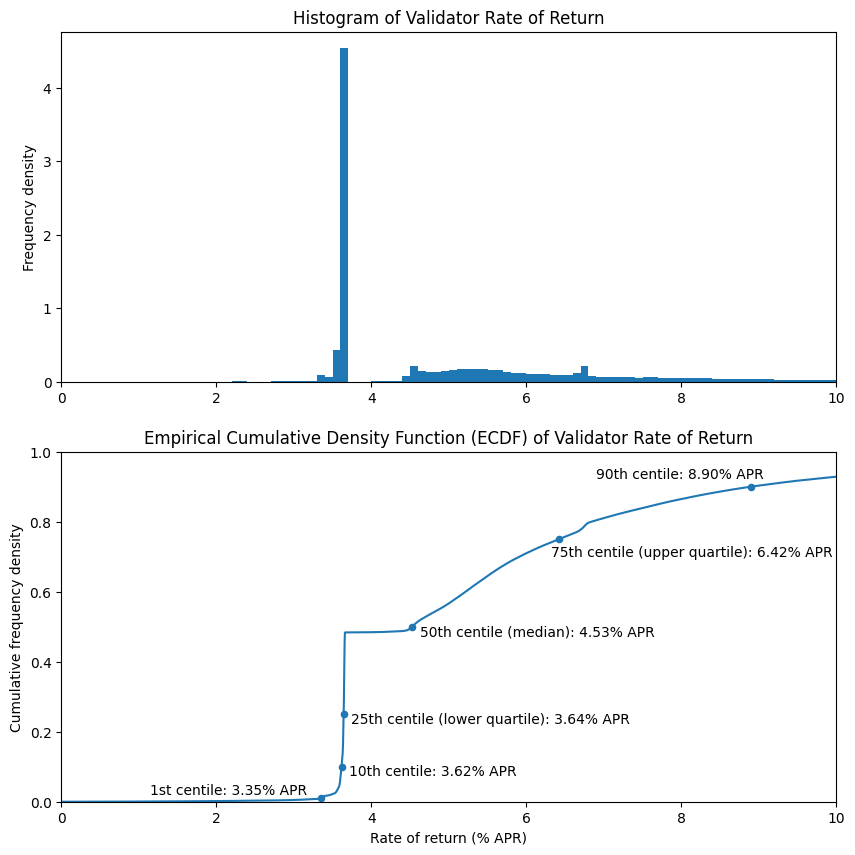

centile(%),return(% APR)
1.0,3.348
10.0,3.616
25.0,3.644
50.0,4.526
75.0,6.419
90.0,8.898
99.0,22.219
99.9,99.892


In [5]:
# calculate ECDF for validator return / plot histogram and ECDF

validators_df = pd.DataFrame([v for v in validator_rewards if v['include']])
validators_df = validators_df[validators_df['include']]

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

validators_df['combined_rewards'] = validators_df['cl_rewards'] + validators_df['el_rewards']
years = (end_slot - start_slot + 1) * 12 / SECONDS_PER_YEAR
validators_df['return'] = 100 * validators_df['combined_rewards'] / 32 / years

bins = [e/10 for e in range(101)]
validators_df['return'].hist(ax=ax1, bins=bins, density=True, grid=False)
ax1.set_title('Histogram of Validator Rate of Return')
ax1.set_xlim(0, 10)
ax1.set_ylabel('Frequency density')
rewards_ecdf = Ecdf(validators_df['combined_rewards'])
return_ecdf = Ecdf(validators_df['return'])

return_ecdf.plot(ax=ax2)

quantiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999]
table = pd.DataFrame({
    'quantile': quantiles,
    'centile<br>(%)': [100 * q for q in quantiles],
    'total revenue<br>(ETH)': [rewards_ecdf.get_quantile(q) for q in quantiles],
    'return<br>(% APR)': [return_ecdf.get_quantile(q) for q in quantiles]
})

table.set_index('quantile', inplace=True, drop=False)
table.plot('return<br>(% APR)', 'quantile', kind='scatter', ax=ax2)

q01 = table['return<br>(% APR)'].loc[0.01]
ax2.annotate(f'1st centile: {q01:.2f}% APR', (q01 - 2.2, 0.02))
q1 = table['return<br>(% APR)'].loc[0.1]
ax2.annotate(f'10th centile: {q1:.2f}% APR', (q1 + 0.1, 0.075))
q25 = table['return<br>(% APR)'].loc[0.25]
ax2.annotate(f'25th centile (lower quartile): {q25:.2f}% APR', (q25 + 0.1, 0.225))
q5 = table['return<br>(% APR)'].loc[0.5]
ax2.annotate(f'50th centile (median): {q5:.2f}% APR', (q5 + 0.1, 0.475))
q75 = table['return<br>(% APR)'].loc[0.75]
ax2.annotate(f'75th centile (upper quartile): {q75:.2f}% APR', (q75 - 0.1, 0.7))
q9 = table['return<br>(% APR)'].loc[0.9]
ax2.annotate(f'90th centile: {q9:.2f}% APR', (q9 - 2, 0.925))
q99 = table['return<br>(% APR)'].loc[0.99]
ax2.annotate(f'99th centile: {q99:.2f}% APR', (q99, 0.925))

ax2.set_xlim(0, 10)
ax2.set_ylim(0, 1)
ax2.set_xlabel('Rate of return (% APR)')
ax2.set_ylabel('Cumulative frequency density')
ax2.set_title('Empirical Cumulative Density Function (ECDF) of Validator Rate of Return')
plt.show()

table[
    ['centile<br>(%)', 'return<br>(% APR)']
].style.set_table_styles(
    [dict(selector='th', props=[('text-align', 'center')])]
).hide().format(
    {'centile<br>(%)': '{:.1f}', 'total revenue<br>(ETH)': '{:.3f}', 'return<br>(% APR)':'{:.3f}'}
)

The above charts and table correspond to the [full model](https://pintail.xyz/posts/post-merge-mev/#modelling-full-validator-returns) from the previous article. This time the distribution looks quite different! However in this case the difference is easy to explain — it is the result of the lumpiness of rewards for block proposal. In this dataset only about half of the validators had the opportunity to propose any blocks at all, so they have yet to receive any rewards on the execution layer. The fairly uniform nature of attestation rewards explains the very large spike on the histogram at about 3.6% APR, and the corresponding step on the ECDF.

Proportion of validators which have not yet proposed any blocks 50.3%
Proportion of validators which have not yet proposed a non-empty block 50.6%


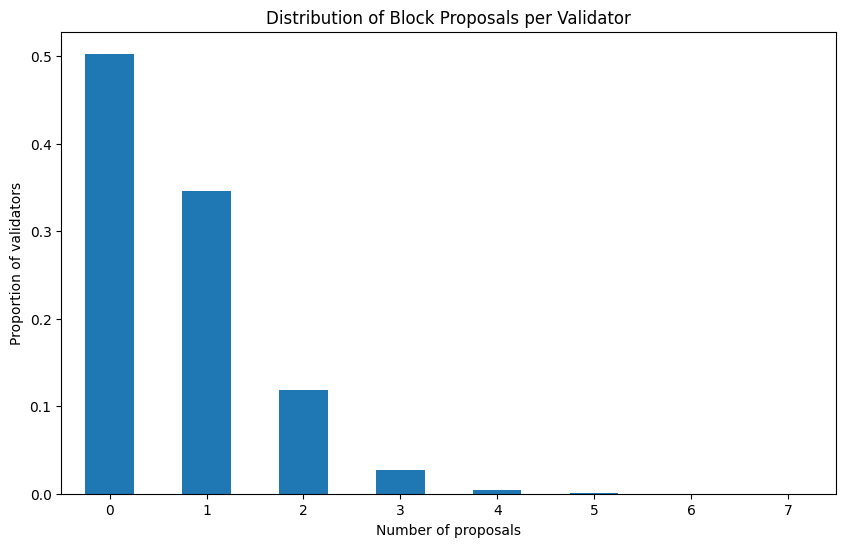

In [6]:
# plot number of proposals frequncy

vc = validators_df['num_proposals'].value_counts(normalize=True).sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
vc.plot(kind='bar', ax=ax, rot=0);

ax.set_title('Distribution of Block Proposals per Validator')
ax.set_xlabel('Number of proposals')
ax.set_ylabel('Proportion of validators')

print(f'Proportion of validators which have not yet proposed any blocks {100*vc[0]:.1f}%')
no_el_rewards = len(validators_df[validators_df['el_rewards'] == 0]) / len(validators_df)
print(f'Proportion of validators which have not yet proposed a non-empty block {100*no_el_rewards:.1f}%')

Again, with only 6 weeks of data, this is completely expected. Over the course of a longer timescale we would expect all validators to have multiple block proposal opportunities, smoothing out the jagged shapes in the charts above and leading to something much closer to our model from the previous article. In the higher end of the distribution at e.g. the 75th and 90th centiles — corresponding to validators which have already proposed multiple blocks — we get perhaps a better sense of how the post-merge data compares to the model. These are both down by about two percentage points, largely due to the lower overall MEV levels we saw in the previous section.

# Execution Layer vs Consensus Layer rewards

As you may be able to tell by looking at the above charts, for the vast majority of validators, consensus layer rewards dominate, and are much less volatile. As shown in the figures below, based on our dataset about 28% of validator rewards come from the execution layer, but for the median validator (who has yet to propose a non-empty block), the execution layer rewards are for now precisely zero.

In [7]:
# proportion of EL versus total rewards

validators_df['el_reward_fraction'] = validators_df['el_rewards'] / validators_df['combined_rewards']

el_reward_fraction = validators_df['el_rewards'].sum() / validators_df['combined_rewards'].sum()
print(f"Overall execution layer reward fraction: {el_reward_fraction:.2f}")
print(f"Median execution layer reward fraction: {validators_df['el_reward_fraction'].median():.2f}")

Overall execution layer reward fraction: 0.28
Median execution layer reward fraction: 0.00


# Validator Groups

Another aspect we previously modelled was the impact of grouping validators together. This question becomes more interesting now, as different groups of validators (for example run by exchanges or liquid staking providers) may choose differing strategies with respect to MEV extraction. The addition of fee recipient/builder payee data also makes it easier to identify groups of validators operated by a single entity.

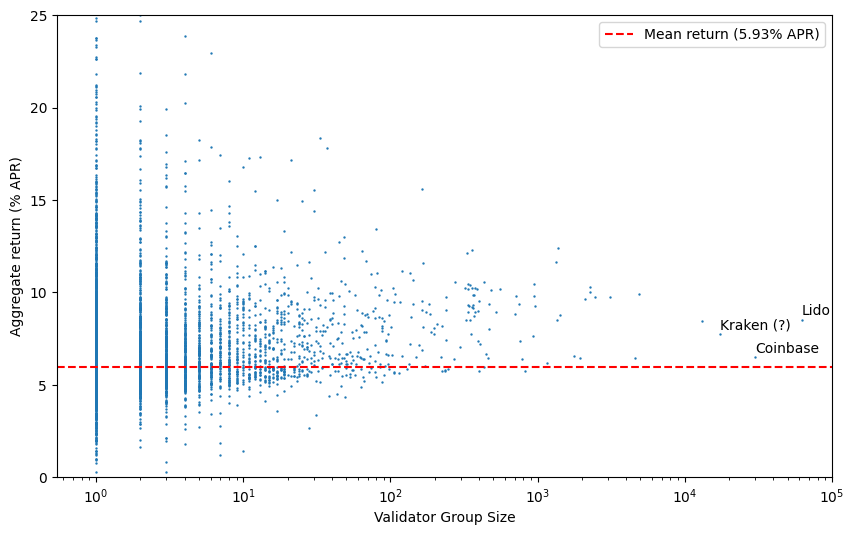

In [8]:
# scatter plot of group size versus rate of return

group_df = validators_df.groupby('builder_payee')['return'].agg(['mean','count'])
group_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))
group_df.plot.scatter(x='count', y='mean', s=0.5, ax=ax)
mean_return = validators_df['return'].mean()
ax.axhline(mean_return, color='r', linestyle='dashed', label=f'Mean return ({mean_return:.2f}% APR)')
ax.set_xscale('log')
ax.set_xlim(xmax=100000)
ax.set_ylim(0, 25)
ax.set_xlabel('Validator Group Size')
ax.set_ylabel('Aggregate return (% APR)')
p = group_df.loc['0x388c818ca8b9251b393131c08a736a67ccb19297'][['count','mean']]
ax.annotate('Lido', (p[0], p[1] + 0.25))
p = group_df.loc['0x4675c7e5baafbffbca748158becba61ef3b0a263'][['count','mean']]
ax.annotate('Coinbase', (p[0], p[1] + 0.25))
p = group_df.loc['0xebec795c9c8bbd61ffc14a6662944748f299cacf'][['count','mean']]
ax.annotate('Kraken (?)', (p[0], p[1] + 0.25))
ax.legend()
plt.show()

In the above scatter plot, each validator group is identified by the number of observed validators which are part of the group (x-axis). However, since these groupings are based on observing proposed blocks, the more than 215k validators who have yet to propose any blocks all appear as a single point — if plotted, this would be off to the right of the chart (with an average rate of return of 3.8% APR). These 'missing' validators also explain why the overall mean rate of return (dashed red line) appears to sit below most of the plotted points. Note that many of these validators in fact are operated by the large node operators (e.g. Lido, Coinbase, Kraken), but are not counted as part of their grouping until they become visible in the data by proposing blocks, which means the APRs for these entities are currently over-reported by this analysis.

Again, it would be valuable to repeat this analysis after a longer period has elapsed as this may show up significant variations in performance between different node operators. For now it is too early to conclude whether there are any significant trends relating to validator group sizes or node operators. No clear trend is obvious from the scatter plot above.

# Block builders

For the rest of this article we're going to look at the trends in block building. As we have already identified where block building has been outsourced, we just need to work out which builder address corresponds to which builder. Below some of the major builder addresses are labeled according to tags found on Etherscan. We're going to use these tagged builder addresses to compare market share and performance for these block builders.

In [9]:
# calculate daily builder counts, totals and mean block values

def get_slot_datetime(slot):
    return datetime.utcfromtimestamp(BEACON_CHAIN_GENESIS_TIMESTAMP + 12 * slot)

builders = { # top builders by blocks in this dataset (based on tags from Etherscan)
    '0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5': 'flashbots',
    '0xb64a30399f7f6b0c154c2e7af0a3ec7b0a5b131a': 'flashbots',
    '0x690b9a9e9aa1c9db991c7721a92d351db4fac990': 'builder0x69.io',
    '0xf2f5c73fa04406b1995e397b55c24ab1f3ea726c': 'bloxroute max profit',
    '0x199d5ed7f45f4ee35960cf22eade2076e95b253f': 'bloxroute regulated',
    '0xf573d99385c05c23b24ed33de616ad16a43a0919': 'bloxroute ethical',
    '0xb646d87963da1fb9d192ddba775f24f33e857128': '0xb646',
    '0xaab27b150451726ec7738aa1d0a94505c8729bd1': 'eden network',
}

keys = {'self built': 0, 'other builder': 0}
for _, v in builders.items():
    keys[v] = 0

start_date = get_slot_datetime(start_slot).date()
end_date = get_slot_datetime(end_slot).date()
num_days = (end_date - start_date).days + 1

daily_builder_counts, daily_builder_totals, daily_builder_mean, daily_builder_median = [], [], [], []
for i in range(num_days):
    daily_builder_counts.append({'date': start_date + timedelta(days=i)})
    daily_builder_totals.append({'date': start_date + timedelta(days=i)})
    daily_builder_mean.append({'date': start_date + timedelta(days=i)})
    daily_builder_median.append({'date': start_date + timedelta(days=i)})
    for k in keys:
        daily_builder_counts[-1][k] = 0
        daily_builder_totals[-1][k] = 0
        daily_builder_mean[-1][k] = 0
        daily_builder_median[-1][k] = []

# count blocks produced by each builder each day, and sum total block values
for index, row in blocks_df.iterrows():
    day = (get_slot_datetime(row['slot']).date() - start_date).days
    if row['fee_recipient'] in builders:
        builder = builders[row['fee_recipient']]
    elif row['fee_recipient'] != row['builder_payee']:
        builder = 'other builder'
    else:
        builder = 'self built'
    daily_builder_counts[day][builder] += 1
    daily_builder_totals[day][builder] += row['block_value']
    daily_builder_median[day][builder].append(row['block_value'])

# calculate mean block value for each builder each day
for day, mean in enumerate(daily_builder_mean):
    for k in mean:
        if k == 'date':
            continue
        if daily_builder_counts[day][k] == 0:
            mean[k] = None
        else:
            mean[k] = daily_builder_totals[day][k] / daily_builder_counts[day][k]

# calculate median block value for each builder each day
for day, values in enumerate(daily_builder_median):
    for k in values:
        if k == 'date':
            continue
        if len(daily_builder_median[day][k]) == 0:
            values[k] = None
        else:
            values[k] = median(values[k])

## Builder Market Share

In the below stacked plot, we can see a clear trend for reduction in proposers building their own blocks down from 81% on the first full day of data down to 39% on the last full day of the dataset. The builder operated by Flashbots initially grew quickly but is gradually being challenged by buidler0x69. BloXroute's set of builders ('max profit', 'regulated' and 'ethical') have held a relatively stable market share over the past few weeks, with other players picking up a relatively small proportion of blocks. Again, as we're looking at only a few weeks of data, it is much too early to know how this market will evolve, except to note that the proportion of validators building their own blocks has continued to drop off fairly consistently since the merge.

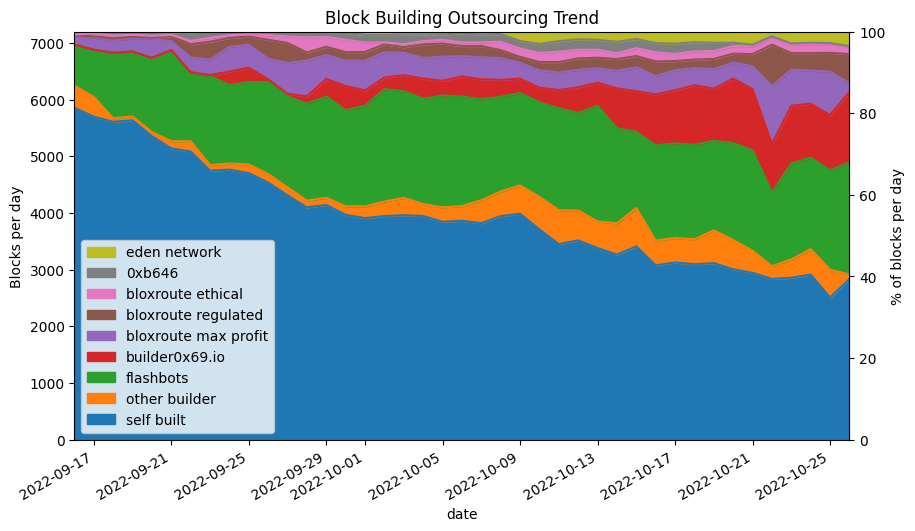

Self-built blocks (2022-09-16): 81.3%
Self-built blocks (2022-10-26): 39.3%


In [10]:
daily_builder_counts_df = pd.DataFrame(daily_builder_counts)
daily_builder_counts_df.set_index('date', inplace=True, drop=False)

fig, ax = plt.subplots(figsize=(10, 6))
daily_builder_counts_df.plot.area(ax=ax)
ax.set_xlim(
    daily_builder_counts_df['date'][1],
    daily_builder_counts_df['date'][-2]
)
blocks_per_day = 60 * 60 * 24 / 12
ax.set_ylim(0, blocks_per_day)
secax = ax.secondary_yaxis('right', functions=(
    lambda k: 100 * k / blocks_per_day, lambda k: k * blocks_per_day / 100
))
secax.set_ylabel('% of blocks per day')
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_ylabel('Blocks per day')
ax.set_title('Block Building Outsourcing Trend')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='lower left')
plt.show()

print(
    f"Self-built blocks ({daily_builder_counts_df['date'][1]}): "
    f"{100 * daily_builder_counts_df['self built'][1] / blocks_per_day:.1f}%"
)
print(
    f"Self-built blocks ({daily_builder_counts_df['date'][-2]}): "
    f"{100 * daily_builder_counts_df['self built'][-2] / blocks_per_day:.1f}%"
)

## Builder Performance — Mean

There are a number of considerations validators will make in order to choose how they outsource block production, but one obvious consideration is builder performance. Which builders are most profitable? In the two charts below we're considering two average measures for builder performance. Firstly the mean daily block value, calculated as the sum of all values (in Ether) of blocks proposed by the builder on a given day, divided by the number blocks. In common parlance this is often just referred to as the 'average'.

The problem with using the mean to compare performance of block builders is that the mean is very sensitive to outliers. As the distribution of block values has a long tail of rare but very high value blocks, the mean block value on days when such a block is built will be much higher. This therefore doesn't give a good sense of overall performance, since all we tend to see is peak where — by random chance — a very valuable block was built by on of the builders, in the form of spikes in the graph. Perhaps the only meaningful conclusion we can draw from this chart is that all of the block builders significantly outperform self-building of blocks by validators.

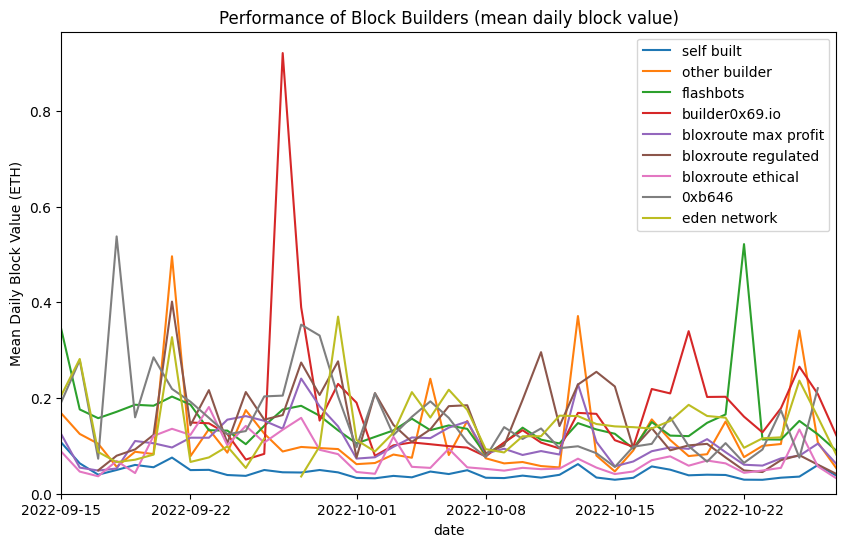

In [11]:
daily_builder_mean_df = pd.DataFrame(daily_builder_mean)
daily_builder_mean_df.set_index('date', inplace=True, drop=False)

fig, ax = plt.subplots(figsize=(10, 6))
daily_builder_mean_df.plot(ax=ax)
ax.set_title('Performance of Block Builders (mean daily block value)')
ax.set_ylabel('Mean Daily Block Value (ETH)')
ax.set_xlim(
    daily_builder_mean_df['date'][0],
    daily_builder_mean_df['date'][-1]
)
ax.set_ylim(ymin=0);

## Builder Performance — Median

Often in such cases a far more useful average measure to use is the median. This is the value of the "middle" block of the day, if the blocks are in a list sorted by value. The median is not affected by occasional random outliers and therefore can often be a better way of comparing datasets which contain such outliers.

In the below chart a bit more of a pattern seems to emerge in the latter half of the dataset, with builder0x69, Eden Network and Flashbots consistently in the lead for block building performance, producing consistently more valuable blocks than any of the BloXroute or other builders. All builders still consistently outperform self-buiding.

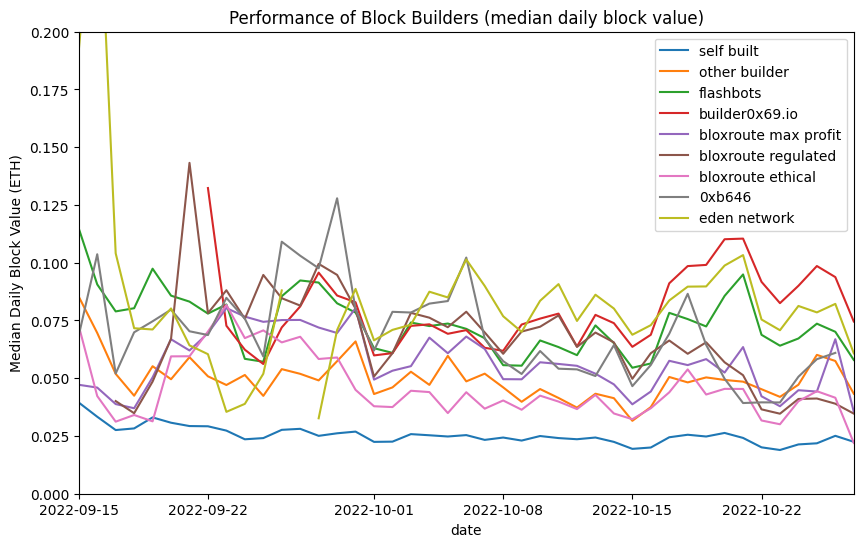

In [12]:
daily_builder_median_df = pd.DataFrame(daily_builder_median)
daily_builder_median_df.set_index('date', inplace=True, drop=False)

fig, ax = plt.subplots(figsize=(10, 6))
daily_builder_median_df.plot(ax=ax)
ax.set_title('Performance of Block Builders (median daily block value)')
ax.set_ylabel('Median Daily Block Value (ETH)')
ax.set_xlim(
    daily_builder_median_df['date'][0],
    daily_builder_median_df['date'][-1]
)
ax.set_ylim(0, 0.2);

## A Word on Relays

In this initial look at post-merge data, I have as usual focused on only on-chain data. As shown above this can still produce some insights, but it does miss an important part of post-merge Ethereum. This is because for the most part validators do not get blocks directly from builders. Rather, they are mediated through *relays*. Relays are trusted parties who intermediate between the block builder and validator who are in general not in a position to trust one another, but each may be willing to enter into a trusted relationship with a relay.

Proposers trust relays to publish valid block bodies for which match the promised value to the proposer, once the proposer signs the block's header. If relays fail to publish the block body, the proposer my lose all reward from proposing since the block will not be accepted by the network without its body. On the other hand, builders trust relays *not to* publish the block bodies before the header has been signed by the proposer, since doing so would leave the MEV they exploit vulnerable to being stolen by other actors.

Proposers may consider blocks from multiple relays and multiple builders before choosing to sign the header of one block which will be added to the chain. So there is a kind of auction happening off-chain, which is not captured in any of the data analysed in this article. The role of relays and competition between block builder is complex and rapidly evolving, and it is not possible to do justice to it in this article, but the reader should be aware that this complexity exists.

# Conclusions

The principal conclusion we can draw from the analysis presented above is that it is too early to make many definitive statements about post-merge validator rewards. A few points are worth drawing out however:

1. Execution layer rewards are lower than they have been during the year prior to the merge. This is most likely due to market conditions rather than being the result of the merge itself.
1. Rates of return for individual validators at that this stage are extremely variable. This is because rewards are "lumpy", and have become more so with the inclusion of execution layer rewards for validators. Around 50% of all validators have yet to propose any blocks, resulting in an APR below 4% for those validators in the mean time.
1. No obvious advantage was found for the big validator pools, but again, it is too soon to have enough data to be certain that this is the case (and for example that validator pools are not engaging in malicious behaviour to maximise their returns).
1. There has been a consistent trend for validators increasingly to outsource block building to third party block builders, with the proportion of validators building their own blocks dropping by more than half during the 6 weeks' data analysed.
1. Third party block builders consistently outperform validators who build their own blocks. Initial data also indicates some variation in performance between builders.